# Multivariate Solana Price Forecasting using LSTM

In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Defining Pytorch Dataset and Dataloader for Multivariate Time Series Forecasting

### Create Pytorch Dataset

In [2]:
class SolanaDataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq, label = self.sequences[idx]

        return dict(
            sequence=torch.Tensor(seq.to_numpy()),
            label=torch.tensor(label).float()
        )

### Create Data Module

In [3]:
class SolanaDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size=32):
        super().__init__()
        self.train_sequences = train_sequences
        self.val_sequences = test_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
    
    def setup(self, stage=None):
        self.train = SolanaDataset(self.train_sequences)
        self.val = SolanaDataset(self.val_sequences)
        self.test = SolanaDataset(self.test_sequences)
    
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=False, num_workers=0)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=1, shuffle=False, num_workers=0)
    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=1, shuffle=False, num_workers=0)


## Getting the Data

In [4]:
import pickle

with open('savedpoints/train_sequences.pkl', 'rb') as f:
    train_sequences = pickle.load(f)

with open('savedpoints/test_sequences.pkl', 'rb') as f:
    test_sequences = pickle.load(f)



### Load the Data

In [5]:
dm = SolanaDataModule(train_sequences=train_sequences, test_sequences=test_sequences, batch_size=32)
dm.setup()

## Creating the LSTM Model

In [6]:
class SolanaLSTMModel(nn.Module):
    #LSTM model for Forecasting 
    def __init__(self, input_size, hidden_size, num_layers):
        super(SolanaLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _)= self.lstm(x)
        out = self.fc(hidden[-1])
        return out

In [7]:
class SolanaPricePredictor(pl.LightningModule):
    def __init__(self, n_features:int, hidden_size:int, num_layers:int):
        super().__init__()
        self.model = SolanaLSTMModel(input_size=n_features, hidden_size=hidden_size, num_layers=num_layers)
        self.loss = nn.MSELoss(reduction='mean')
    
    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        
        if labels is not None:
            loss = self.loss(output, labels)
        
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label'][0]

        loss, outputs = self(sequences, labels)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label'][0]

        loss, outputs = self(sequences, labels)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label'][0]

        loss, outputs = self(sequences, labels)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer    


In [8]:
model = SolanaPricePredictor(n_features=12, hidden_size=64, num_layers=2)

## Preparing the Callbacks

#### Setup Tensorboard

In [9]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 8464), started 1 day, 1:17:30 ago. (Use '!kill 8464' to kill it.)

#### Callbacks

In [10]:
from pytorch_lightning.loggers import TensorBoardLogger

In [12]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='solana-lstm-{epoch:02d}-{val_loss:.2f}-{v_num:d}',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name="solana-lstm-price")

early_stopping = EarlyStopping('val_loss', patience=10)


trainer = pl.Trainer(
    logger=logger,
    enable_model_summary=True,
    callbacks=[early_stopping, checkpoint_callback],
    max_epochs=70,
    enable_progress_bar=True,
)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model, dm)

e:\My Projects\solana-forecasting-using-lstm\env\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory E:\My Projects\solana-forecasting-using-lstm\checkpoints exists and is not empty.

  | Name  | Type            | Params
------------------------------------------
0 | model | SolanaLSTMModel | 53.3 K
1 | loss  | MSELoss         | 0     
------------------------------------------
53.3 K    Trainable params
0         Non-trainable params
53.3 K    Total params
0.213     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\My Projects\solana-forecasting-using-lstm\env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


e:\My Projects\solana-forecasting-using-lstm\env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 765/765 [00:43<00:00, 17.52it/s, v_num=15, train_loss=0.000151, val_loss=0.106]

Epoch 0, global step 765: 'val_loss' reached 0.10583 (best 0.10583), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=00-val_loss=0.11-v_num=00.ckpt' as top 1


Epoch 1: 100%|██████████| 765/765 [00:42<00:00, 17.92it/s, v_num=15, train_loss=7.94e-5, val_loss=0.107] 

Epoch 1, global step 1530: 'val_loss' was not in top 1


Epoch 2: 100%|██████████| 765/765 [00:42<00:00, 18.11it/s, v_num=15, train_loss=7.17e-5, val_loss=0.103] 

Epoch 2, global step 2295: 'val_loss' reached 0.10314 (best 0.10314), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=02-val_loss=0.10-v_num=00.ckpt' as top 1


Epoch 3: 100%|██████████| 765/765 [00:45<00:00, 16.83it/s, v_num=15, train_loss=1.61e-5, val_loss=0.100] 

Epoch 3, global step 3060: 'val_loss' reached 0.10036 (best 0.10036), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=03-val_loss=0.10-v_num=00.ckpt' as top 1


Epoch 4: 100%|██████████| 765/765 [00:42<00:00, 17.80it/s, v_num=15, train_loss=4.61e-5, val_loss=0.0994]

Epoch 4, global step 3825: 'val_loss' reached 0.09942 (best 0.09942), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=04-val_loss=0.10-v_num=00.ckpt' as top 1


Epoch 5: 100%|██████████| 765/765 [00:42<00:00, 17.92it/s, v_num=15, train_loss=2.87e-5, val_loss=0.107]  

Epoch 5, global step 4590: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 765/765 [00:42<00:00, 17.88it/s, v_num=15, train_loss=1.57e-5, val_loss=0.111] 

Epoch 6, global step 5355: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 765/765 [00:42<00:00, 17.96it/s, v_num=15, train_loss=6.82e-6, val_loss=0.113] 

Epoch 7, global step 6120: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 765/765 [00:43<00:00, 17.77it/s, v_num=15, train_loss=1.92e-5, val_loss=0.114] 

Epoch 8, global step 6885: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 765/765 [00:42<00:00, 17.83it/s, v_num=15, train_loss=1.59e-5, val_loss=0.111] 

Epoch 9, global step 7650: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 765/765 [00:42<00:00, 17.89it/s, v_num=15, train_loss=2.69e-5, val_loss=0.109] 

Epoch 10, global step 8415: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 765/765 [00:42<00:00, 17.93it/s, v_num=15, train_loss=1.75e-5, val_loss=0.107] 

Epoch 11, global step 9180: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 765/765 [00:42<00:00, 17.98it/s, v_num=15, train_loss=8.48e-6, val_loss=0.103] 

Epoch 12, global step 9945: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 765/765 [00:42<00:00, 17.85it/s, v_num=15, train_loss=1.6e-5, val_loss=0.0997] 

Epoch 13, global step 10710: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 765/765 [00:42<00:00, 17.96it/s, v_num=15, train_loss=7.15e-6, val_loss=0.0855] 

Epoch 14, global step 11475: 'val_loss' reached 0.08548 (best 0.08548), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=14-val_loss=0.09-v_num=00.ckpt' as top 1


Epoch 15: 100%|██████████| 765/765 [00:42<00:00, 17.96it/s, v_num=15, train_loss=3.58e-6, val_loss=0.0753] 

Epoch 15, global step 12240: 'val_loss' reached 0.07530 (best 0.07530), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=15-val_loss=0.08-v_num=00.ckpt' as top 1


Epoch 16: 100%|██████████| 765/765 [00:42<00:00, 17.97it/s, v_num=15, train_loss=1.24e-5, val_loss=0.0882] 

Epoch 16, global step 13005: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 765/765 [00:42<00:00, 17.97it/s, v_num=15, train_loss=8.79e-6, val_loss=0.0822] 

Epoch 17, global step 13770: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 765/765 [00:42<00:00, 17.94it/s, v_num=15, train_loss=5.78e-5, val_loss=0.0694] 

Epoch 18, global step 14535: 'val_loss' reached 0.06937 (best 0.06937), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=18-val_loss=0.07-v_num=00.ckpt' as top 1


Epoch 19: 100%|██████████| 765/765 [00:42<00:00, 17.83it/s, v_num=15, train_loss=8.11e-5, val_loss=0.0593] 

Epoch 19, global step 15300: 'val_loss' reached 0.05930 (best 0.05930), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=19-val_loss=0.06-v_num=00.ckpt' as top 1


Epoch 20: 100%|██████████| 765/765 [00:42<00:00, 17.97it/s, v_num=15, train_loss=1.73e-5, val_loss=0.0593] 

Epoch 20, global step 16065: 'val_loss' reached 0.05928 (best 0.05928), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=20-val_loss=0.06-v_num=00.ckpt' as top 1


Epoch 21: 100%|██████████| 765/765 [00:42<00:00, 17.95it/s, v_num=15, train_loss=1.08e-5, val_loss=0.0608] 

Epoch 21, global step 16830: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 765/765 [00:42<00:00, 17.91it/s, v_num=15, train_loss=2.05e-5, val_loss=0.0568] 

Epoch 22, global step 17595: 'val_loss' reached 0.05683 (best 0.05683), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=22-val_loss=0.06-v_num=00.ckpt' as top 1


Epoch 23: 100%|██████████| 765/765 [00:42<00:00, 17.85it/s, v_num=15, train_loss=1.77e-5, val_loss=0.0494] 

Epoch 23, global step 18360: 'val_loss' reached 0.04937 (best 0.04937), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=23-val_loss=0.05-v_num=00.ckpt' as top 1


Epoch 24: 100%|██████████| 765/765 [00:42<00:00, 17.93it/s, v_num=15, train_loss=1.98e-5, val_loss=0.0408] 

Epoch 24, global step 19125: 'val_loss' reached 0.04083 (best 0.04083), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=24-val_loss=0.04-v_num=00.ckpt' as top 1


Epoch 25: 100%|██████████| 765/765 [00:42<00:00, 17.83it/s, v_num=15, train_loss=0.000106, val_loss=0.0332]

Epoch 25, global step 19890: 'val_loss' reached 0.03316 (best 0.03316), saving model to 'E:\\My Projects\\solana-forecasting-using-lstm\\checkpoints\\solana-lstm-epoch=25-val_loss=0.03-v_num=00.ckpt' as top 1


Epoch 26: 100%|██████████| 765/765 [00:42<00:00, 17.95it/s, v_num=15, train_loss=4.45e-5, val_loss=0.0417] 

Epoch 26, global step 20655: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 765/765 [00:42<00:00, 17.87it/s, v_num=15, train_loss=0.000123, val_loss=0.0431]

Epoch 27, global step 21420: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 765/765 [00:43<00:00, 17.74it/s, v_num=15, train_loss=4.28e-5, val_loss=0.0438] 

Epoch 28, global step 22185: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 765/765 [00:42<00:00, 17.92it/s, v_num=15, train_loss=6.4e-5, val_loss=0.0428]  

Epoch 29, global step 22950: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 765/765 [00:43<00:00, 17.78it/s, v_num=15, train_loss=6.63e-5, val_loss=0.0531] 

Epoch 30, global step 23715: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 765/765 [00:42<00:00, 17.95it/s, v_num=15, train_loss=4.66e-5, val_loss=0.0554] 

Epoch 31, global step 24480: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 765/765 [00:42<00:00, 17.80it/s, v_num=15, train_loss=4.19e-5, val_loss=0.0658] 

Epoch 32, global step 25245: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 765/765 [00:42<00:00, 17.92it/s, v_num=15, train_loss=0.000187, val_loss=0.0683]

Epoch 33, global step 26010: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 765/765 [00:42<00:00, 17.91it/s, v_num=15, train_loss=0.000111, val_loss=0.0807]

Epoch 34, global step 26775: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 765/765 [00:43<00:00, 17.63it/s, v_num=15, train_loss=0.000502, val_loss=0.0876]

Epoch 35, global step 27540: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 765/765 [00:43<00:00, 17.63it/s, v_num=15, train_loss=0.000502, val_loss=0.0876]


## Using the TRained Model

In [11]:
trained_model = SolanaPricePredictor.load_from_checkpoint("checkpoints/solana-lstm-epoch=25-val_loss=0.03-v_num=00.ckpt", n_features=12, hidden_size=64, num_layers=2)

In [12]:
trained_model.freeze()

In [13]:
tests_dataset = SolanaDataset(test_sequences)

In [14]:
from tqdm import tqdm
def test_model(trained_model, tests_dataset):
    predictions = []
    actuals = []

    for item in tqdm(tests_dataset):
        sequences = item['sequence'].unsqueeze(0)
        label = item['label']
        _, output = trained_model(sequences)
        predictions.append(output.item())
        actuals.append(label.item())
    

    return predictions, actuals

In [15]:
pred, actual = test_model(trained_model, tests_dataset)

100%|██████████| 5923/5923 [00:07<00:00, 747.29it/s]


In [17]:
with open('savedpoints/descaler.pkl', 'rb') as f:
    descaler = pickle.load(f)

In [18]:
def descale(x):
    descaler_local = descaler
    x_val = np.array(x)[:, np.newaxis]
    return descaler_local.inverse_transform(x_val).flatten()

In [19]:
predictions_desc = descale(pred)

In [20]:
labels_desc = descale(actual)

In [21]:
predictions_desc[:5]

array([18.77080844, 18.77198146, 18.7792113 , 18.78273039, 18.7886032 ])

In [22]:
labels_desc[:5]

array([15.590001  , 15.590001  , 15.56000062, 15.56000062, 15.590001  ])

In [26]:
with open('savedpoints/test_non.pkl', 'rb') as f:
    test_non = pickle.load(f)

In [27]:
test_data = test_non.iloc[254:]

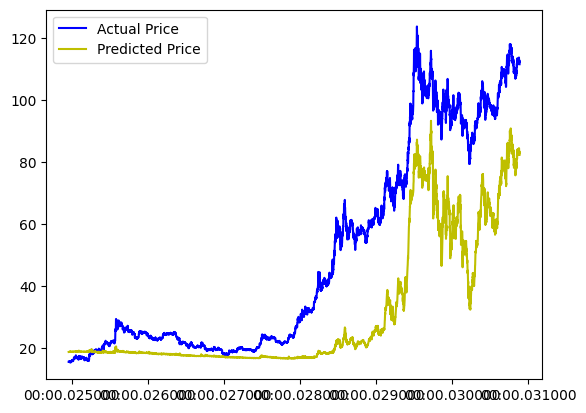

In [30]:
from matplotlib import dates

dates = dates.date2num(test_data.index)

plt.plot_date(dates, labels_desc, 'b-', label='Actual Price')
plt.plot_date(dates, predictions_desc, 'y-', label='Predicted Price')
plt.legend()